In [1]:
from laserembeddings import Laser
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

/home/yzhong/conda/envs/env_test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yzhong/conda/envs/env_test/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prepare dataset

In [8]:
def find_star (df):
    return ( df['headline_org'].str.contains(r'^\*[\u4e00-\u9fff0-9a-zA-Z].*'))
def get_TF(x, info_list):
    return any([True for i in info_list if i in str(x)])
def find_words(df, col_name='body', my_words=None):
    
    if my_words is None:
        my_words = ['原文标题','彭博自动新闻','原文標題']
        return (df[col_name].apply(lambda x: get_TF(x, my_words)))  
df_c=pd.read_parquet('/mnt/research-live/user/yzhong/bloomberg_news_chinese_trickers_translation.parquet')  
df=pd.read_parquet('/mnt/research-live/user/yzhong/chinese_english_sentiment_bert_chinese.parquet')
#df=df_sim.copy(deep=True)
mask1=find_star(df_c)
mask2=find_words(df_c)
# df['contains_star']=mask1
# df['contains_words']=mask2
df_c['Only_Ch']= (~mask1) & (~mask2)
df_merged = df.merge(df_c[['suid', 'Only_Ch']], on='suid', how='left')

In [10]:
df_merged.to_parquet('/mnt/research-live/user/yzhong/chinese_english_sentiment_bert_chinese.parquet')

In [11]:
df=pd.read_parquet('/mnt/research-live/user/yzhong/chinese_english_sentiment_bert_chinese.parquet')
df = df.sort_values(by=['last_update'], ascending=True).reset_index(drop=True)

In [12]:
df.columns

Index(['suid', 'last_update', 'language', 'analyst', 'date', 'headline',
       'translation', 'tickers', 'match', 'match_cs_headline', 'match_cs_cos',
       'match_cs_date', 'match_cs_suid', 'negative', 'positive', 'neutral',
       'negative_zero', 'positive_zero', 'neutral_zero', 'negative_chinese',
       'positive_chinese', 'sentiment_english_finbert',
       'sentiment_english_zero', 'sentiment_chinese', 'eqt_codes', 'Only_Ch'],
      dtype='object')

In [13]:
chinese_sentences=df.headline

In [14]:
laser=Laser()
chinese_emb=laser.embed_sentences(chinese_sentences,lang='zh')

In [15]:
np.save('/mnt/research-live/user/yzhong/chinese_embedding.npy', chinese_emb)

## Ridge regression

Input data feature

In [16]:
# Load the embedding data from your dataframe into X
X = chinese_emb

# Load the multioutput data from your dataframe into y
y = np.array(df[['positive', 'negative', 'neutral']])

Time-based cross-validation

In [17]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000000,
    test_size=10000,
)

make pipeline

In [18]:
# Define your pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1e-4))
])

Train model

In [75]:
# Define the number of splits for the time series cross-validation
n_splits = 5
# Create a TimeSeriesSplit object with n_splits
tscv = TimeSeriesSplit(n_splits=n_splits)
# Define empty lists to store the training and testing MSE for each output variable
#train_mse_neg,train_mse_pos,train_mse_neu,test_mse_neg,test_mse_pos,test_mse_neu = [], [], [], [], [], []
# Define empty arrays to store the predicted values and actual values
y_train_pred = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
y_test_pred = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
y_train_actual = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
y_test_actual = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
# Define the batch size
batch_size = 256
# Define the number of epochs
n_epochs = 2
# Define the model
regressor = Ridge(alpha=1e-4,fit_intercept=True)
# Define the scaler
scaler = StandardScaler()
# Define the pipeline
pipeline = Pipeline(steps=[('scaler', scaler), ('regressor', regressor)])
# Perform time series cross-validation with training, testing and loss calculation in each epoch

Evaluate the model

In [95]:
import matplotlib.pyplot as plt

# Define a list of alpha values to test
#alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
#alphas = [1e-4, 1,100,1e4,1e6]
alphas = [1e8,1e10,1e12,1e14]

# Define empty lists to store the mean test MSE for each alpha
# train_mse_neg_mean = []
# train_mse_pos_mean = []
# train_mse_neu_mean = []

# test_mse_neg_mean = []
# test_mse_pos_mean = []
# test_mse_neu_mean = []


# Perform time series cross-validation for each alpha value
for alpha in alphas:
    # Define the pipeline with the current alpha value
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha,fit_intercept=True))
    ])
    # Define empty lists to store the test MSE for each fold
    train_mse_neg = []
    train_mse_pos = []
    train_mse_neu = []
    test_mse_neg = []
    test_mse_pos = []
    test_mse_neu = []

    # Define empty arrays to store the predicted values and actual values
    y_train_pred = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
    y_test_pred = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
    y_train_actual = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
    y_test_actual = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])

    # Perform time series cross-validation
    for i, (train_index, test_index) in enumerate(ts_cv.split(df)):
        # Split the data into training and test sets
        X_train, X_test = chinese_emb[train_index], chinese_emb[test_index]
        y_train, y_test = df.loc[train_index, ['negative', 'positive', 'neutral']], df.loc[test_index, ['negative', 'positive', 'neutral']]
        # Fit the pipeline to the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the pipeline on the training data
        y_train_pred[train_index] = pipeline.predict(X_train)
        y_train_actual[train_index] = y_train
        train_mse_neg.append(mean_squared_error(y_train['negative'], y_train_pred[train_index][:,0]))
        train_mse_pos.append(mean_squared_error(y_train['positive'], y_train_pred[train_index][:,1]))
        train_mse_neu.append(mean_squared_error(y_train['neutral'], y_train_pred[train_index][:,2]))



        # Evaluate the pipeline on the test data
        y_test_pred[test_index] = pipeline.predict(X_test)
        y_test_actual[test_index] = y_test
        test_mse_neg.append(mean_squared_error(y_test['negative'], y_test_pred[test_index][:,0]))
        test_mse_pos.append(mean_squared_error(y_test['positive'], y_test_pred[test_index][:,1]))
        test_mse_neu.append(mean_squared_error(y_test['neutral'], y_test_pred[test_index][:,2]))
    # Calculate the mean test MSE for each output variable
    test_mse_neg_mean.append(np.mean(test_mse_neg))
    test_mse_pos_mean.append(np.mean(test_mse_pos))
    test_mse_neu_mean.append(np.mean(test_mse_neu))
    # Calculate the mean train MSE for each output variable
    train_mse_neg_mean.append(np.mean(train_mse_neg))
    train_mse_pos_mean.append(np.mean(train_mse_pos))
    train_mse_neu_mean.append(np.mean(train_mse_neu))

# Plot the results
# plt.plot(alphas, test_mse_neg_mean, label='Negative')
# plt.plot(alphas, test_mse_pos_mean, label='Positive')
# plt.plot(alphas, test_mse_neu_mean, label='Neutral')
# plt.plot(alphas, train_mse_neg_mean, label='Negative')
# plt.plot(alphas, train_mse_pos_mean, label='Positive')
# plt.plot(alphas, train_mse_neu_mean, label='Neutral')
# plt.xscale('log')
# plt.xlabel('Alpha')
# plt.ylabel('Mean Test MSE')
# plt.legend()
# plt.show()

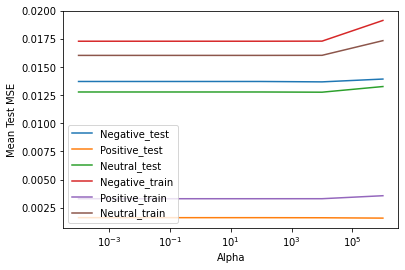

In [93]:
# Plot the results
plt.plot(alphas, test_mse_neg_mean, label='Negative_test')
plt.plot(alphas, test_mse_pos_mean, label='Positive_test')
plt.plot(alphas, test_mse_neu_mean, label='Neutral_test')
plt.plot(alphas, train_mse_neg_mean, label='Negative_train')
plt.plot(alphas, train_mse_pos_mean, label='Positive_train')
plt.plot(alphas, train_mse_neu_mean, label='Neutral_train')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Test MSE')
plt.legend()
plt.show()

In [2]:
chinese_emb = np.load('/mnt/research-live/user/yzhong/my_array.npy')

In [19]:


# Define the number of splits for the time series cross-validation
n_splits = 5

# Create a TimeSeriesSplit object with n_splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define your pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1e-4))
])

# Define empty lists to store the MSE for each output variable
mse_neg = []
mse_pos = []
mse_neu = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(df):
    # Split the data into training and test sets
    X_train, X_test = chinese_emb[train_index], chinese_emb[test_index]
    y_train, y_test = df.loc[train_index, ['positive', 'negative', 'neutral']], df.loc[test_index, ['positive', 'negative', 'neutral']]
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Evaluate the pipeline on the test data
    y_pred = pipeline.predict(X_test)
    
    # Calculate the MSE for each output variable and store the results
    mse_neg.append(mean_squared_error(y_test['negative'], y_pred[:,0]))
    mse_pos.append(mean_squared_error(y_test['positive'], y_pred[:,1]))
    mse_neu.append(mean_squared_error(y_test['neutral'], y_pred[:,2]))

# Calculate the mean MSE for each output variable over all cross-validation folds
mean_mse_neg = np.mean(mse_neg)
mean_mse_pos = np.mean(mse_pos)
mean_mse_neu = np.mean(mse_neu)

# Print the mean MSE for each output variable
print('Negative MSE: {:.2f}'.format(mean_mse_neg))
print('Positive MSE: {:.2f}'.format(mean_mse_pos))
print('Neutral MSE: {:.2f}'.format(mean_mse_neu))

Negative MSE: 0.04
Positive MSE: 0.03
Neutral MSE: 0.02


In [71]:
y_pred_neg =y_pred[:, 0]
# Get the actual values for the negative column
y_true_neg = df['negative'].values
# Calculate the correlation coefficient
corr_coef_neg = np.corrcoef(y_pred_neg, y_true_neg)[0, 1]
# Print the correlation coefficient
print('Correlation coefficient for negative column:', corr_coef_neg)

Correlation coefficient for negative column: 0.7085035948966508


In [ ]:

# Get the predicted values for the negative column
y_pred_neg = pipeline.predict(chinese_emb)[:, 0]

# Get the actual values for the negative column
y_true_neg = df['negative'].values

# Calculate the correlation coefficient
corr_coef_neg = np.corrcoef(y_pred_neg, y_true_neg)[0, 1]

# Print the correlation coefficient
print('Correlation coefficient for negative column:', corr_coef_neg)


In [72]:
for i, col in enumerate (['negative', 'positive', 'neutral']):
    mse=mean_squared_error(df[col], y_pred[:,i])
    mae=mean_absolute_error(df[col], y_pred[:,i])
    corr_coef = np.corrcoef( y_pred[:,i], df[col].values)[0, 1]
    r2 = r2_score(df[col], y_pred[:,i])
    print('Output column: {}'.format(col))
    print('MSE: {:.2f}'.format(mse))
    print('Correlation: {:.2f}'.format(corr_coef))
    print('MAE: {:.2f}'.format(mae))
    print('R-squared: {:.2f}'.format(r2))
    print()


Output column: negative
MSE: 0.02
Correlation: 0.71
MAE: 0.09
R-squared: 0.50

Output column: positive
MSE: 0.00
Correlation: 0.63
MAE: 0.03
R-squared: 0.39

Output column: neutral
MSE: 0.02
Correlation: 0.71
MAE: 0.09
R-squared: 0.51



In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict the output values for the entire dataset
y_pred = pipeline.predict(chinese_emb)

# Calculate the evaluation metrics
mse = mean_squared_error(df[['negative', 'positive', 'neutral']], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df[['negative', 'positive', 'neutral']], y_pred)
r2 = r2_score(df[['negative', 'positive', 'neutral']], y_pred)

# Print the evaluation metrics
print('MSE: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('R-squared: {:.2f}'.format(r2))

MSE: 0.01
RMSE: 0.11
MAE: 0.07
R-squared: 0.47


In [20]:
from joblib import dump

# Save the trained pipeline to disk
dump(pipeline, '/mnt/research-live/user/yzhong/ridge_finbert_chinese.joblib')

['/mnt/research-live/user/yzhong/ridge_finbert_chinese.joblib']

In [ ]:
from joblib import load

# Load the saved pipeline from disk
loaded_pipeline = load('your_trained_model.joblib')

In [ ]:
from joblib import load

# Load the saved pipeline from disk
loaded_pipeline = load('your_trained_model.joblib')

predictions = loaded_pipeline.predict(new_data)
print(predictions)

In [47]:
# Load the saved Ridge model using joblib
ridge = joblib.load('ridge_model.pkl')

In [12]:
chinese_emb.shape

(674324, 1024)

In [6]:
df['laser_embedding']=chinese_emb.tolist()

In [49]:
df = df.sort_values(by=['last_update'], ascending=True).reset_index(drop=True)

In [30]:
del df['index']

## Random forest regression

In [3]:
chinese_emb = np.load('/mnt/research-live/user/yzhong/my_array.npy')

In [4]:
# Perform time series cross-validation 
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000000,
    test_size=10000,
)
# Define the pipeline with the current alpha value
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Define empty lists to store the test MSE for each fold
train_mse_neg = []
train_mse_pos = []
train_mse_neu = []
test_mse_neg = []
test_mse_pos = []
test_mse_neu = []

# Define empty arrays to store the predicted values and actual values
y_train_pred = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
y_test_pred = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
y_train_actual = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])
y_test_actual = np.empty_like(df.loc[:, ['negative', 'positive', 'neutral']])

# Perform time series cross-validation
for i, (train_index, test_index) in enumerate(ts_cv.split(df)):
    # Split the data into training and test sets
    X_train, X_test = chinese_emb[train_index], chinese_emb[test_index]
    y_train, y_test = df.loc[train_index, ['negative', 'positive', 'neutral']], df.loc[test_index, ['negative', 'positive', 'neutral']]
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Evaluate the pipeline on the training data
    y_train_pred[train_index] = pipeline.predict(X_train)
    y_train_actual[train_index] = y_train
    train_mse_neg.append(mean_squared_error(y_train['negative'], y_train_pred[train_index][:,0]))
    train_mse_pos.append(mean_squared_error(y_train['positive'], y_train_pred[train_index][:,1]))
    train_mse_neu.append(mean_squared_error(y_train['neutral'], y_train_pred[train_index][:,2]))
    # Evaluate the pipeline on the test data
    y_test_pred[test_index] = pipeline.predict(X_test)
    y_test_actual[test_index] = y_test
    test_mse_neg.append(mean_squared_error(y_test['negative'], y_test_pred[test_index][:,0]))
    test_mse_pos.append(mean_squared_error(y_test['positive'], y_test_pred[test_index][:,1]))
    test_mse_neu.append(mean_squared_error(y_test['neutral'], y_test_pred[test_index][:,2]))


In [ ]:
# Calculate the mean MSE for each output variable over all cross-validation folds
mean_train_mse_neg = np.mean(train_mse_neg)
mean_train_mse_pos = np.mean(train_mse_pos)
mean_train_mse_neu = np.mean(train_mse_neu)

mean_test_mse_neg = np.mean(test_mse_neg)
mean_test_mse_pos = np.mean(test_mse_pos)
mean_test_mse_neu = np.mean(test_mse_neu)


# Print the mean MSE for each output variable
print('Train Negative MSE: {:.2f}'.format(mean_train_mse_neg))
print('Train Positive MSE: {:.2f}'.format(mean_train_mse_pos))
print('Train Neutral MSE: {:.2f}'.format(mean_train_mse_neu))

# Print the mean MSE for each output variable
print('Test Negative MSE: {:.2f}'.format(mean_test_mse_neg))
print('Test Positive MSE: {:.2f}'.format(mean_test_mse_pos))
print('Test Neutral MSE: {:.2f}'.format(mean_test_mse_neu))